# DLT Model

**DLT** stands for Damped Local Trend model, which is an important model type in *orbit* package.

$$ y_{t}  = \hat{y}_t + \epsilon $$
$$\hat{y}_t=\mu_t + s_t + r_t $$
$$\mu_t=D(t) + l_{t-1} +  \theta{b_{t-1}}$$

with the update process as such 

$$g_t = D(t)$$
$$l_t = \rho_l(y_t - g_{t} - s_t - r_t) + (1-\rho_l)l_{t-1}$$
$$b_t=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)\theta{b_{t-1}}$$
$$s_{t+m} =  \rho_s(y_t - l_t - r_t) + (1-\rho_s)s_t$$
$$r_t =  \Sigma_{j}\beta_j x_{jt}$$

There are a few choices of $D(t)$ as a global trend, such as linear, log-linear and logistic. Another feature of DLT is the regression component $r_t$. This serves the purpose of nowcasting or forecasting when exogenous regressors are known such as events and holidays.  Without losing generality, assume

$$\beta_j ~\sim \mathtt{Normal}(\mu_j, \sigma_j)$$

where $\mu_j = 0$  and $\sigma_j = 1$ by default as a non-informative prior. There are more choices of priors for the regression component in the package.

Just like LGT, DLT is a variation of traditional exponential smoothing models.  The difference between `DLT` and `LGT` are mainly:

- It introduces a damped factor on local trend
- It models global trend as a determinstic projection

There are four options in modeling the `global trend` with the `global_trend_option` arguemnt:

1. `linear`
2. `loglinear`
3. `logistic`
4. `flat`

In orbit, we have three different wrappers for DLT typed models, `DLTMAP`, `DLTAggregated`, `DLTFull`.

In [1]:
import pandas as pd
import numpy as np
from orbit.models.dlt import DLTMAP, DLTFull, DLTAggregated
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components

## Data

First, let's load the example data set.

In [2]:
df = pd.read_csv("../../examples/data/iclaims_example.csv", parse_dates=["week"])
df["claims"] = np.log(df["claims"])
date_col='week'
response_col='claims'

## MAP Fit and Predict

### Linear Trend

Now let's instantiate a DLT model with the MAP inference method.

In [3]:
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=2020,
    global_trend_option='linear',
)

In [4]:
dlt.fit(df)

In [5]:
from datetime import timedelta
num_periods = 52 * 4
freq = 7
date_col = dlt.date_col
last_dt = (df[date_col].dt.to_pydatetime())[-1]
dts = [last_dt + timedelta(days=x * freq) for x in range(1, num_periods + 1)]
future_df = pd.DataFrame(dts, columns=[date_col])

In [6]:
predicted_df = dlt.predict(df=future_df, decompose=True)

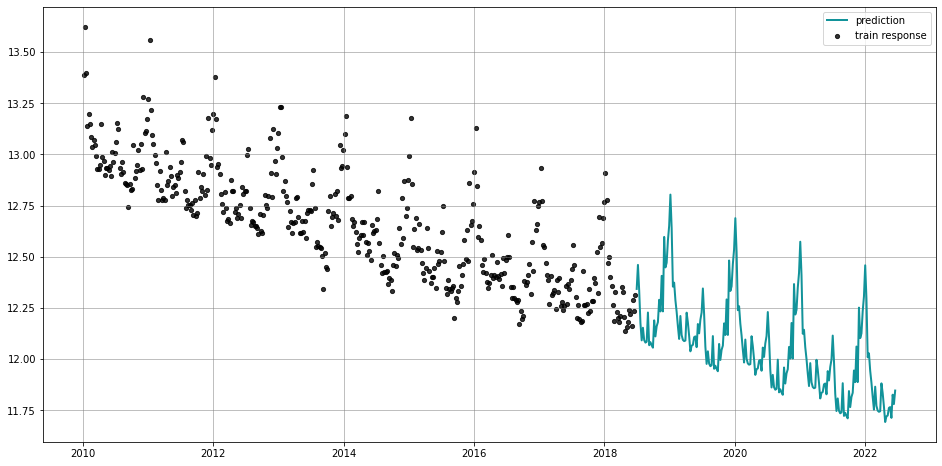

In [7]:
plot_predicted_data(training_actual_df=df, predicted_df=predicted_df, 
                    date_col=dlt.date_col, actual_col=dlt.response_col, pred_col='prediction')

### Log-Linear Trend

For users who want to maintain linear trend assumption in the multiplicative model, they can switch to `loglinear` global trend.  

In [8]:
dlt_log = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=2020,
    global_trend_option='loglinear',
)

In [9]:
dlt_log.fit(df=df)

In [10]:
predicted_df_dlt_log = dlt_log.predict(df=future_df, decompose=True)

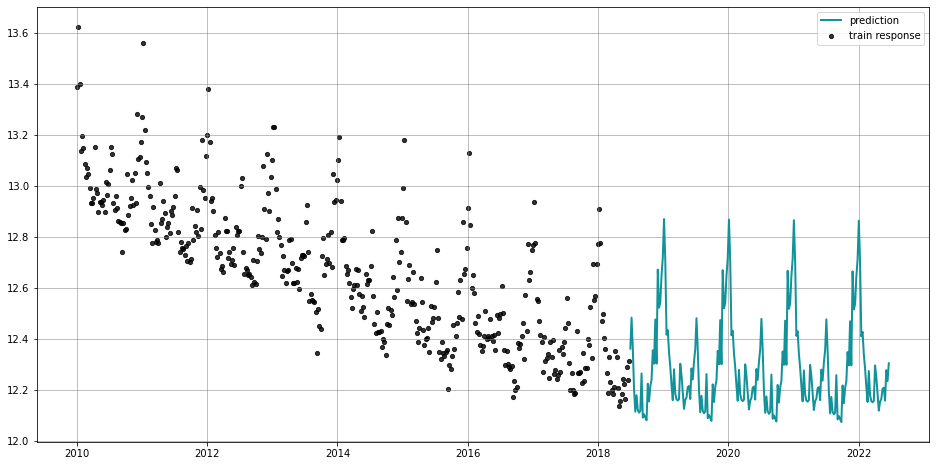

In [11]:
plot_predicted_data(training_actual_df=df, predicted_df=predicted_df_dlt_log, 
                    date_col=dlt_log.date_col, actual_col=dlt_log.response_col, pred_col='prediction')

### Logistic Global Trend

In case of modeling logistic growth/decay, user can switch to `logistic` in the `global_trend_option`. 

In [12]:
dlt_logit = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=2020,
    global_trend_option='logistic',
)

In [13]:
dlt_logit.fit(df=df)

In [14]:
predicted_df_dlt_logit = dlt_logit.predict(df=future_df, decompose=True)

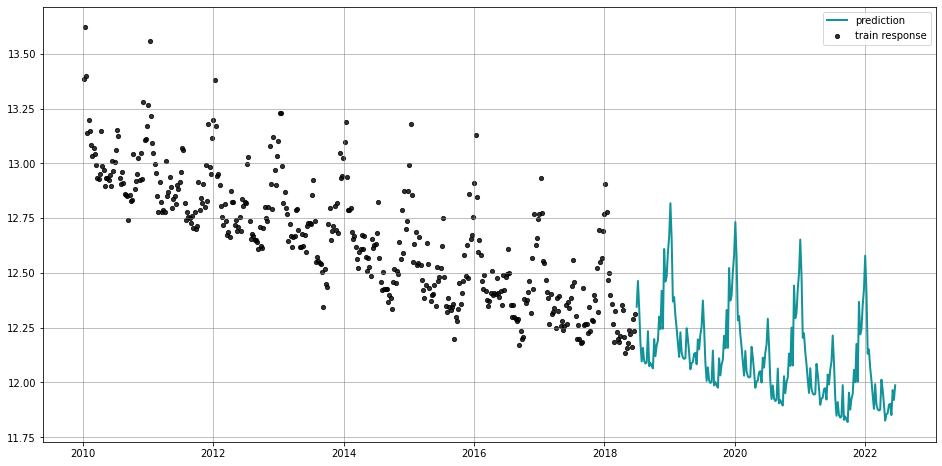

In [15]:
plot_predicted_data(training_actual_df=df, predicted_df=predicted_df_dlt_logit, 
                    date_col=dlt_log.date_col, actual_col=dlt_log.response_col, pred_col='prediction')

### Flat Global Trend

In [16]:
dlt_logit = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=2020,
    global_trend_option='flat',
)

In [17]:
dlt_logit.fit(df=df)

In [18]:
predicted_df_dlt_logit = dlt_logit.predict(df=future_df, decompose=True)

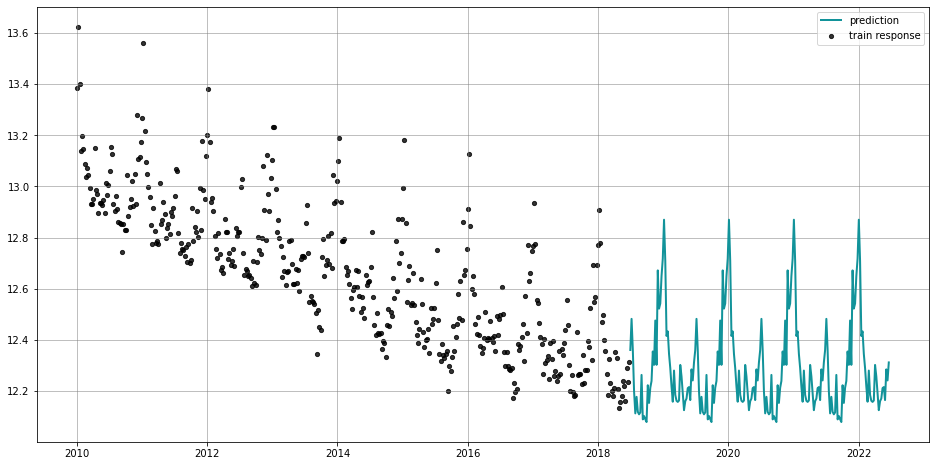

In [19]:
plot_predicted_data(training_actual_df=df, predicted_df=predicted_df_dlt_logit, 
                    date_col=dlt_log.date_col, actual_col=dlt_log.response_col, pred_col='prediction')

## MCMC Fit and Predictict

Now let's instantiate a DLT model with MCMC inference.

In [20]:
dlt = DLTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=2020,
    global_trend_option='linear',
    prediction_percentiles=[5, 95],
)

In [21]:
dlt.fit(df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [22]:
predicted_df = dlt.predict(df=future_df)

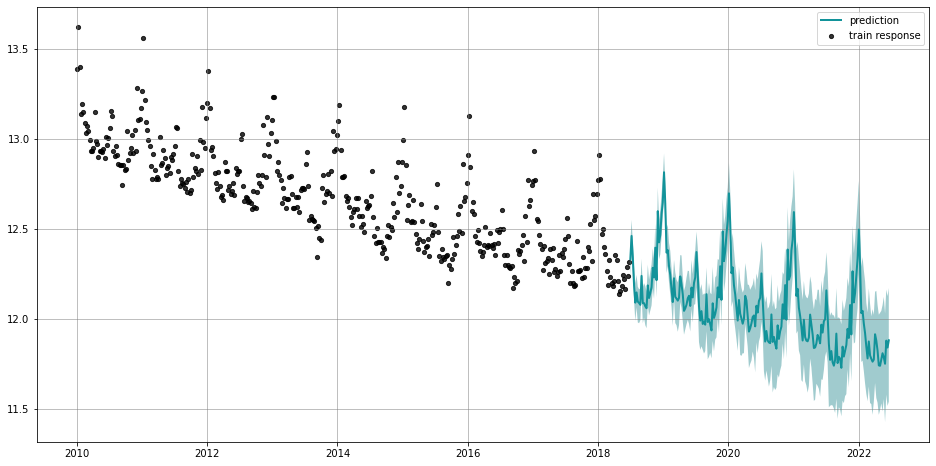

In [23]:
plot_predicted_data(training_actual_df=df, predicted_df=predicted_df, 
                    date_col=dlt.date_col, actual_col=dlt.response_col, pred_col='prediction')